In [1]:
!pip install split-folders

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# import zipfile
# zip_file_path = '/content/drive/MyDrive/Brain Tumor Data Set.zip'
# extract_dir = '/content/drive/MyDrive/Brain Tumor Data Set'

# # Ensure the extract directory exists
# os.makedirs(extract_dir, exist_ok=True)

# # Step 3: Unzip the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

In [4]:
os.listdir("/content/drive/MyDrive/data")

['Testing', 'Training']

In [10]:
# data_dir = "/content/drive/MyDrive/data"
# data_dir = pathlib.Path(data_dir)

# splitfolders.ratio(data_dir, output='brain', seed=41, ratio=(0.8, 0.2))

import pathlib
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path for training and testing data
training_data_dir = "/content/drive/MyDrive/data/Training"  # Update this path as needed
testing_data_dir = "/content/drive/MyDrive/data/Testing"  # Update this path as needed

# Create ImageDataGenerator instances for training and testing data
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalizing the images
test_datagen = ImageDataGenerator(rescale=1./255)

# Use flow_from_directory for training and testing
train_generator = train_datagen.flow_from_directory(
    training_data_dir,
    target_size=(150, 150),  # Resize images as needed
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    testing_data_dir,
    target_size=(150, 150),  # Resize images as needed
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [15]:
# data_dir = "/content/brain"
# data_dir = pathlib.Path(data_dir)

class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        # Using a pretrained ResNet18 for transfer learning
        self.resnet = torchvision.models.resnet18(pretrained=True)

        # Modify the final layer for 4 classes (pituitary, glioma, notumor, meningioma)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 4)

    def forward(self, x):
        return self.resnet(x)

# Initialize the model
model = BrainTumorCNN()

# Check the model architecture
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


BrainTumorCNN(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [18]:
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [19]:
# Example model (you can customize the architecture)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes (glioma, meningioma, notumor, pituitary)
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Save the model after training
model.save("brain_tumor_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6027 - loss: 1.0039

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 747s 4s/step - accuracy: 0.6033 - loss: 1.0022 - val_accuracy: 0.7930 - val_loss: 0.5052
Epoch 2/10
  1/178 ━━━━━━━━━━━━━━━━━━━━ 3:43 1s/step - accuracy: 0.7500 - loss: 0.5271

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.7500 - loss: 0.5271 - val_accuracy: 0.7977 - val_loss: 0.5066
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.8504 - loss: 0.3951 - val_accuracy: 0.8844 - val_loss: 0.2938
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.8438 - loss: 0.3600 - val_accuracy: 0.8867 - val_loss: 0.2857
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.9126 - loss: 0.2380 - val_accuracy: 0.9195 - val_loss: 0.2159
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9062 - loss: 0.4391 - val_accuracy: 0.9156 - val_loss: 0.2188
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9451 - loss: 0.1596 - val_accuracy: 0.9336 - val_loss: 0.1775
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.9375 - loss: 0.1264 - val_accuracy: 0.9344 - val_loss: 0.1807
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.9529 - loss: 0.1374 - val_accurac

In [22]:
# train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Training'), transform=transform)
# train_set.transform
# val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Testing'), transform=transform)
# val_set.transform

import pathlib

data_dir = pathlib.Path("/content/drive/MyDrive/data")  # Correct path

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

train_set = torchvision.datasets.ImageFolder(data_dir / 'Training', transform=transform)
val_set = torchvision.datasets.ImageFolder(data_dir / 'Testing', transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)

print("Classes:", train_set.classes)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [23]:
print(train_set)

Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /content/drive/MyDrive/data/Training
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


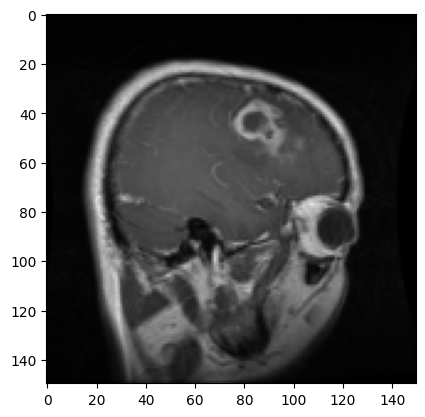

In [24]:
img, label = train_set[1000]
plt.imshow(img.permute(1,2,0))

In [25]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [26]:
next(iter(val_loader))[0].shape

torch.Size([64, 3, 150, 150])

In [30]:
# class CNNModel(nn.Module):
#   def __init__(self):
#     super(CNNModel, self).__init__()

#     #Conv 1
#     self.cnv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #128-5+1=124

#     #Max Pool 1
#     self.maxpool1 = nn.MaxPool2d(kernel_size=2) #124/2 = 64

#     #Conv 2
#     self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #60

#     #Max Pool 2
#     self.maxpool2 = nn.MaxPool2d(kernel_size=2) #30

#     #Conv 3
#     self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0) #26

#     #Max Pool 3
#     self.maxpool3 = nn.MaxPool2d(kernel_size=2) #13

#     #Conv 4
#     self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0) #9

#     #Max Pool 4
#     self.maxpool4 = nn.MaxPool2d(kernel_size=2) #4

#     #Activation Function
#     self.leakyRelu = nn.LeakyReLU()

#     #Fully connected Layer 1
#     self.fc1 = nn.Linear(128*4*4, 1024)

#     #Fully connected Layer 2
#     self.fc2 = nn.Linear(1024, 2)

#   def forward(self, x):
#     #Layer 1
#     out = self.leakyRelu(self.cnv1(x))
#     out = self.maxpool1(out)

#     #Layer 2
#     out = self.leakyRelu(self.cnv2(out))
#     out = self.maxpool2(out)

#     #Layer 3
#     out = self.leakyRelu(self.cnv3(out))
#     out = self.maxpool3(out)

#     #Layer 4
#     out = self.leakyRelu(self.cnv4(out))
#     out = self.maxpool4(out)

#     #flatten
#     out = out.view(out.size(0), -1)

#     # Linear Function
#     out = self.leakyRelu(self.fc1(out))
#     out = self.fc2(out)

#     return out


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Conv 1
        self.cnv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)  # 128-5+1=124

        # Max Pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)  # 124/2 = 64

        # Conv 2
        self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)  # 60

        # Max Pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)  # 30

        # Conv 3
        self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)  # 26

        # Max Pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)  # 13

        # Conv 4
        self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0)  # 9

        # Max Pool 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)  # 4

        # Activation Function
        self.leakyRelu = nn.LeakyReLU()

        # Fully connected Layer 1
        # Updated input features to match the output of convolutional layers
        self.fc1 = nn.Linear(128 * 5 * 5, 1024)  # Input features = 3200

        # Fully connected Layer 2
        # Updated output features to match 4 classes in the dataset
        self.fc2 = nn.Linear(1024, 4)

    def forward(self, x):
        # Layer 1
        out = self.leakyRelu(self.cnv1(x))
        out = self.maxpool1(out)

        # Layer 2
        out = self.leakyRelu(self.cnv2(out))
        out = self.maxpool2(out)

        # Layer 3
        out = self.leakyRelu(self.cnv3(out))
        out = self.maxpool3(out)

        # Layer 4
        out = self.leakyRelu(self.cnv4(out))
        out = self.maxpool4(out)

        # Flatten
        out = out.view(out.size(0), -1)

        # Linear Function
        out = self.leakyRelu(self.fc1(out))
        out = self.fc2(out)

        return out

In [31]:
# Training CNN
num_epochs = 10
model = CNNModel()
error = nn.CrossEntropyLoss()

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [32]:
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
  train_loss = 0
  val_loss = 0
  for i, (images, labels) in enumerate(train_loader):

    optimizer.zero_grad()
    outputs = model(images)
    loss = error(outputs, labels)
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print("Loss in Iteration:", i, ":", loss.item())
  total = 0
  correct = 0
  for images, labels in val_loader:
    outputs = model(images)
    v_loss = error(outputs, labels)
    val_loss+=v_loss.item()
    predicted = torch.max(outputs.data, 1)[1]

    total+=len(labels)
    correct+=(predicted==labels).sum()


  scheduler.step(val_loss/len(val_loader))
  accuracy = 100*correct/float(total)
  train_loss_list.append(train_loss/len(train_loader))
  val_loss_list.append(val_loss/len(val_loader))
  accuracy_list.append(accuracy)
  print("Epoch:{}  Loss:{}  Acciracy:{}%".format(epoch, train_loss/len(train_loader), accuracy))

Loss in Iteration: 0 : 1.3875658512115479
Loss in Iteration: 1 : 1.4038149118423462
Loss in Iteration: 2 : 1.3693296909332275
Loss in Iteration: 3 : 1.4576560258865356
Loss in Iteration: 4 : 1.3438726663589478
Loss in Iteration: 5 : 1.353002905845642
Loss in Iteration: 6 : 1.2581419944763184
Loss in Iteration: 7 : 1.2511144876480103
Loss in Iteration: 8 : 1.174038290977478
Loss in Iteration: 9 : 1.1373997926712036
Loss in Iteration: 10 : 1.1931383609771729
Loss in Iteration: 11 : 1.2057785987854004
Loss in Iteration: 12 : 1.0408023595809937
Loss in Iteration: 13 : 1.0275661945343018
Loss in Iteration: 14 : 1.193214774131775
Loss in Iteration: 15 : 0.9833531975746155
Loss in Iteration: 16 : 1.1407233476638794
Loss in Iteration: 17 : 1.015427827835083
Loss in Iteration: 18 : 1.1047983169555664
Loss in Iteration: 19 : 0.9938809871673584
Loss in Iteration: 20 : 0.8222929239273071
Loss in Iteration: 21 : 1.1170310974121094
Loss in Iteration: 22 : 0.7431508898735046
Loss in Iteration: 23 : 0

In [33]:
train_loss_list

[0.8281613296932644,
 0.5003353433476554,
 0.395605378680759,
 0.28331944661007985,
 0.213753539406591,
 0.16417962544494205,
 0.09693903405633238,
 0.07139314159543977,
 0.07315203587835034,
 0.06066106461609403]

In [34]:
val_loss_list

[0.7212054019882566,
 0.5273804338205428,
 0.479053258895874,
 0.32100532665139153,
 0.2558981531432697,
 0.2219464264455296,
 0.15671644625919207,
 0.21660032194285167,
 0.18810383762632096,
 0.11352794236015706]

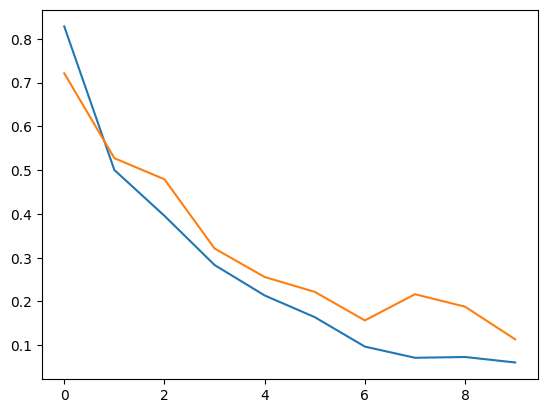

In [35]:
plt.plot(range(num_epochs), train_loss_list)
plt.plot(range(num_epochs), val_loss_list)

In [36]:
accuracy_list

[tensor(69.4127),
 tensor(78.7948),
 tensor(80.9306),
 tensor(87.1854),
 tensor(90.2365),
 tensor(92.6011),
 tensor(94.5843),
 tensor(92.8299),
 tensor(94.2792),
 tensor(96.8726)]

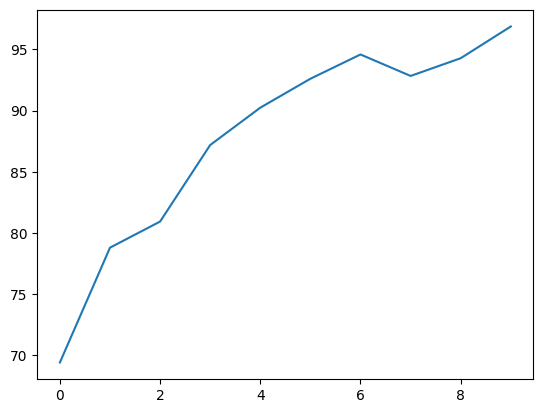

In [37]:
plt.plot(range(num_epochs), accuracy_list)

Text(0.5, 1.0, '1')

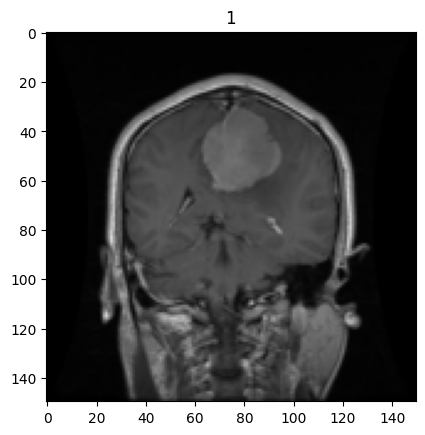

In [38]:
img, label = val_set[500]
plt.imshow(img.permute(1,2,0))
plt.title(label)

In [39]:
image = img.unsqueeze(5)

with torch.no_grad():
  output = model(image)

_, pred = torch.max(output, 1)
print("Predicted Output:", pred.item())

Predicted Output: 1
